In [1]:
import numpy as np
import scipy.linalg as la
from scipy import sparse
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
from scipy.optimize import minimize,basinhopping
import cvxpy as cvx
from qutip import *

This is a quick and inefficient MaxCut prototype using QuTiP

In [2]:
# Number of qubits
N= 4

In [3]:
# Define Operators 
def gen_cij(edge):
    i,j = edge
    Id = [qeye(2) for n in range(N)]
    si_n = tensor(Id)
    Id[i] = sigmaz()
    Id[j] = sigmaz()
    zij = tensor(Id)
    return 0.5*(si_n - zij)

def gen_B():
    b_op = 0*tensor([qeye(2) for j in range(N)])
    for i in range(N):
        Id = [qeye(2) for j in range(N)]
        Id[i] = sigmax()
        b_op += tensor(Id)
    return b_op

def gen_init():
    init = tensor([basis(2,0) for i in range(N)])
    x_all = tensor([hadamard_transform(1) for i in range(N)])
    return (x_all*init).unit()



In [4]:
ψ_init = gen_init()
edges = [[0,1],[1,2],[2,3],[3,0]]
C = np.sum(gen_cij(edge) for edge in edges)
B = gen_B()

In [5]:
def gen_U(angles):
    L = len(angles)
    γs = angles[:int(L/2)] 
    βs = angles[int(L/2):]
    U = np.prod([(-1j*βs[i]*B).expm()*(-1j*γs[i]*C).expm() for i in range(int(L/2))]) 
    return U 

In [164]:
def cost(angles,info):
    U_temp = gen_U(angles)
    ψ_temp = U_temp*ψ_init
    energy = -expect(C,ψ_temp) + (np.random.rand() * 2 -1) * 0.05
    
    info['Nfeval'] += 1
    print(info, sep=' ', end='\r', flush=True)
    return energy

## Comparing some optimization routines

### Single layer

In [165]:
num_layers = 1

In [166]:
sol_NM = minimize(cost,np.random.rand(2*num_layers),args=({'Nfeval':0}),method='Nelder-Mead',options={'maxiter':100})

In [167]:
sol_NM.x,sol_NM.fun

(array([0.02258422, 0.29257107]), -2.091405326147797)

In [168]:
sol_BFGS = minimize(cost,np.random.rand(2*num_layers),args=({'Nfeval':0}),method='BFGS')

In [169]:
sol_BFGS.x,sol_BFGS.fun

(array([0.41317773, 0.97510631]), -1.5367591904761977)

In [176]:
# Get Random Samples
sample_size = 1000
sample_size_reduced = 50
rand_angles = np.array([2 * np.pi  * i/sample_size for i in range(sample_size)])
np.random.shuffle(rand_angles)
angles_sampled = rand_angles[:sample_size_reduced]

qaoa_sampled = []
for angle in angles_sampled:
    qaoa_sampled.append(cost([angle, 0.39269913], {'Nfeval':0}))                

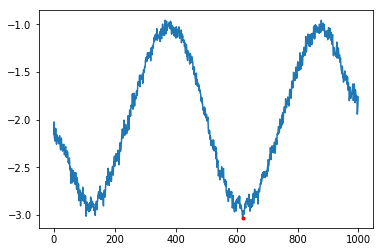

-3.0449432196522337

In [177]:
# Reconstruct and draw
from sparse_reconstruction import reconstruct_from_signal
import matplotlib.pyplot as plt
sparse_signal = reconstruct_from_signal(angles_sampled, qaoa_sampled, error=0)
idx = np.argmin(sparse_signal)
angle_opt = idx * 2 * np.pi / len(sparse_signal)

plt.plot(sparse_signal)
plt.plot(idx, sparse_signal[idx], marker='o', markersize=3, color="red")
plt.show()

cost([angle_opt, 0.39269913], {'Nfeval':0})


### Two layers

In [56]:
num_layers = 2 

In [57]:
sol_NM = minimize(cost,np.random.rand(2*num_layers),args=({'Nfeval':0}),method='Nelder-Mead')

In [58]:
sol_NM.x,sol_NM.fun

(array([0.70243793, 0.39794949, 0.28687161, 0.27761626]), -3.2605269956461265)

In [59]:
sol_BFGS = minimize(cost,np.random.rand(2*num_layers),args=({'Nfeval':0}),method='BFGS')

/usr/local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [60]:
sol_BFGS.x,sol_BFGS.fun

(array([0.0024832 , 0.41912955, 0.07147249, 0.65400422]), -2.1871294430881822)

## Comparing with Rigetti's solution

In [17]:
ψ_init = gen_init()
angle_list = [2.35394,1.18] #[γ,β]
U_mat = gen_U(angle_list)
ψ = U_mat*ψ_init 

energy = expect(C,ψ)
print(f"The optimized value is {energy}")

The optimized value is 2.9999608711896224


Plotting the wavefuntion weights

<BarContainer object of 16 artists>

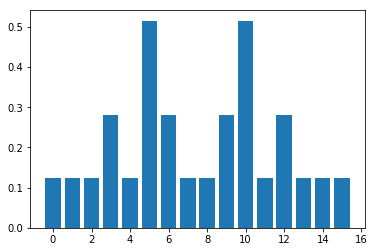

In [18]:
plt.bar(np.arange(16),np.abs(ψ.full()).flatten())